# Notebook for developing the algorithm for a changing number of communities
We focus on batched and sequential Gibbs for homogeneous SBM with a prior on k

## Preliminary Steps

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import math

# Generate data
np.random.seed(0)

# parameters needed for the simulation
p = 0.17
q = 0.08
n = 400
k = 4
n_k = 100
T = 100
burn_in = 0

I = -2 * np.log((p*q)**0.5 +((1-p)* (1-q))**0.5 )

# generate the network
z_ex = np.repeat(np.arange(k), n_k)
A, z_true = generate_homogeneous_sbm(n, k, p, q, z_t=z_ex)

alpha = 0.2 # warm/cold initialization
z_0 = warm_initializer(z_true, alpha, n ,k)

# Prior values
alpha_p_pri = 1
beta_p_pri = 1  

alpha_q_pri = 1
beta_q_pri = 1
gamma = 1


### Prior on k

Here we perform a little study on the influence of the choice of the parameter $\tilde{\gamma}$ on the "Pareto-type" prior we set on the number of communities:
$$
K \sim \mathbb{P}(K =k) = \frac{\tilde{\gamma}(1-\tilde{\gamma})_{k-1}}{k!}
$$

0.1866058200923072

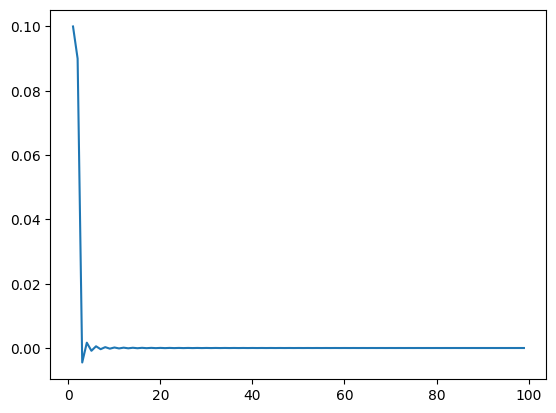

In [3]:
def descending_factorial(n, k):
    # l = np.arange(n-k+1, n+1, 1)
    # l = [i if i>0 else 1 for i in l]
    # return np.prod(l)
    return np.prod(np.arange(n-k+1, n+1, 1))

def species_prior(k, gamma=0.1):
    return gamma * descending_factorial(1-gamma, k-1)/math.factorial(k-1)

x = list(range(1, 100))
y = [species_prior(i) for i in x]
plt.plot(x,y)

np.sum(y)

## Heterogeneous SBM with number of communities to be estimated

to do list:
- build the proper generator for the heterogeneous SBM (with sampled P)


In [7]:
import tqdm
from tqdm import tqdm

class Geng_sequential_sampler():

    def __init__(self, A, z_0, homogeneous = False):
        self.homogeneous = homogeneous
        # data
        self.A = A
        self.z = z_0.copy()
        
        self.n = len(self.z)
        self.k = len(np.unique(self.z)) #initial number of communities is provided by the initialization

        #initializing prior parameters
        self.alpha_prior = 1
        self.beta_prior = 1
        self.gamma = 1
        self.gamma_tilde = 1/2

        if not homogeneous: pass

        #lists for analyses
        self.z_list=[self.z]
        self.k_list = []
        self.P_list=[np.ones(k,k)/k] #store P matrices

        #posterior parameters (no need for pi: it's "collapsed out")
        self.alpha = None
        self.beta = None

        # for an easier sampling form in the updates
        self.pi = np.zeros(self.n, self.k)

        #sampled
        self.P = None #to store the probabilities

        self.Z = one_hot_encode(self.z)

    def __beta_updates(self):

        N = self.Z.T @ self.Z - np.eye(self.k)
        A_bar = self.Z.T @ self.A @ self.Z #no need to avoid i=j since A_{ii}=0 

        self.alpha = self.alpha_prior + A_bar
        self.beta = self.beta_prior + N - A_bar

        return

    def __z_updates(self, append = True):
        """
        Update the community assignments based on the current beta parameters.
        """
        Z_aux = self.Z
        z_aux = self.z
        clean = False
        for i in tqdm(range(self.n)):
            # see if k_{-i} is k

            if np.sum(self.Z[:, self.z[i]])==1:
                k_i = self.k-1
                old_z = self.z[i]
                clean = True
            else:
                k_i = self.k
        
            existing_probs = gamma * np.ones(self.k) + (np.ones((1,self.n)) - np.eye(self.n)[i,:]) @ self.Z # prior term
            existing_probs *= self.__likelihood_term(i)
            new_prob = k_i * (k_i * self.gamma_tilde) * gamma * self.__compute_marginal_likelihood(i, k_i)
            probs=np.concatenate([existing_probs, new_prob])
            new_prob /= np.sum(probs)
            existing_probs /= np.sum(probs[:-1])

            # sample from the probabilities
            if np.random.uniform() < probs[-1]: #probability of a new community
                self.z[i] = self.k #new community
                self.k += 1
            else:
                self.z[i] = np.random.choice(np.arange(self.k), p=existing_probs)
            self.Z = one_hot_encode(self.z) # update Z (includes new community update)

            # clean z and Z of possibly emptied communities
            # a community gets emptied if and only if i was the only node in it and it changed community
            if clean and self.z[i] != old_z:
                self.k -= 1
                self.z = np.array([j-1 if j>old_z else j for j in self.z])
                self.Z = one_hot_encode(self.z)

        if append:
            self.z_list.append(self.z)
            self.k_list.append(self.k)
            self.P_list.append(self.P)

            
    def __likelihood_term(self, i):
        # in the batched algorithm it will be convenient to write it in matrix form using the log likelihood
        return np.prod(self.P[self.z[i], self.z] ** self.A[i,:] * (1 - self.P[self.z[i], self.z]) ** (1 -np.eye(n)[i,:] - self.A[i,:]))

    def __compute_marginal_likelihood(self, i, k_i):
        beta_prior = math.beta(self.alpha_prior, self.beta_prior) #scalar
        a_prime = self.alpha_prior + np.sum(self.A[i,:] @ self.Z)
        b_prime = self.beta_prior + (np.ones(n) - np.eye(n)[i,:]) @ self.Z - np.sum(self.A[i,:] @ self.Z) #vectors of size k
        beta_post = math.beta(a_prime, b_prime) #it's a vector of size k
        return np.prod(beta_post)/beta_prior


    def step(self, append_z = True):
        """
        Perform one step of the Gibbs sampling algorithm.

        Parameters:
        - append_z: bool, whether to append the current community assignments to the z_list

        Returns:
        None
        """
        self.__beta_updates()
        # sample from the parameters found above: each entry of P has a beta distribution with the parameters
        # contained in matrices alpha and beta
        self.P = np.random.beta(self.alpha, self.beta)
        # acutally, only the upper triangular part of P is needed, since it is symmetric
        self.P = np.triu(self.P, 1) + np.triu(self.P, 1).T

        self.__z_updates(append = append_z)
    
    def run(self, num_iterations, burn_in = 0):
        """
        Run the Gibbs sampler for a specified number of iterations.

        Parameters:
        - num_iterations: int, number of iterations to run the sampler
        - burn_in: int, number of burn-in iterations to discard

        Returns:
        None
        """
        for t in tqdm(range(num_iterations)):
            self.step(append_z = (t >= burn_in))

    def get_z_list(self):
        """
        Get the list of community assignments at each step.

        Returns:
        list: list of numpy arrays representing community assignments
        """
        return self.z_list
    
    def get_p_list(self):
        """
        Get the list of sampled p values at each step.

        Returns:
        list: list of floats representing sampled p values
        """
        return self.p_list
    
    def get_q_list(self):
        """
        Get the list of sampled q values at each step.

        Returns:
        list: list of floats representing sampled q values
        """
        return self.q_list